# Preperations
## Imports

In [46]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import time

In [47]:
# Define compute device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# set seed for reproducibility
torch.manual_seed(42)

Using cuda device


## Dataset

In [48]:
# download cifar10 dataset
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [49]:
# Create data loaders as baseline for the models - might be changed for later models
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Models
## Base Model
I'm planning to first demonstrate the inneficiancy of a fully connected model on the CIFAR10 dataset.

### Model architecture

In [50]:
class base_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [61]:
# Training loop
def train(dataloader, model, loss_function, optimizer, epochs):
    loss_values = []
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        size = len(dataloader.dataset)
        total_loss = 0
        correct = 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            # Compute prediction error
            pred = model(X)
            loss = loss_function(pred, y)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Log the loss and accuracy
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        avg_loss = total_loss / len(dataloader)
        accuracy = correct / size
        loss_values.append(avg_loss)
        print(f"Loss: {avg_loss:>8f}, Accuracy: {(100*accuracy):>0.1f}%")
        
    return loss_values
        

In [52]:
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    
    accuracy = 100 * correct
    avg_loss = test_loss
    
    return accuracy, avg_loss

In [53]:
def calculate_bias_variance(model, dataloader, num_samples=100):
    model.eval()
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            true_values.append(y.cpu().numpy())
            preds = []
            for _ in range(num_samples):
                preds.append(model(X).cpu().numpy())
            predictions.append(np.mean(preds, axis=0))
    
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)
    
    # Convert true_values to one-hot encoding
    true_values_one_hot = np.eye(predictions.shape[1])[true_values]
    
    bias = np.mean((predictions - true_values_one_hot) ** 2)
    
    variance = np.mean(np.var(predictions, axis=0))
    
    return bias, variance

In [54]:
def plot_loss(loss_values):
    plt.plot(loss_values, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [59]:
def run_experiment(model, learning_rate=1e-3, epochs=5, optimizer_name='adam',weight_decay=None, momentum=None, save_path=None):
    start_time = time.time()
    model = model.to(device)
    
    # Set the optimizer parameters if specified in the function call
    optimizer_params = {'lr': learning_rate}
    if weight_decay:
        optimizer_params['weight_decay'] = weight_decay
    
    # Initialize the optimizer based on the optimizer name
    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), **optimizer_params)
        
    elif optimizer_name.lower() == 'sgd':
        if momentum: # Check if momentum is specified only for SGD
            optimizer_params['momentum'] = momentum
        optimizer = torch.optim.SGD(model.parameters(), **optimizer_params)
    else:
        raise ValueError("Invalid optimizer name")
    
    # Initialize the loss function
    loss_function = nn.CrossEntropyLoss()
    
    loss_values = train(train_dataloader, model, loss_function, optimizer, epochs)
    
    test_accuracy, test_loss = test(test_dataloader, model, loss_function)
    bias, variance = calculate_bias_variance(model, test_dataloader)
    
    print(f"Time taken: {time.time() - start_time} seconds")
    print("Test results:")
    
    print(f"Test Error: \n Accuracy: {test_accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")
    
    print( f"Bias: {bias}, Variance: {variance}")
    
    plot_loss(loss_values)
    
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Saved PyTorch Model State to {save_path}")
    

In [ ]:
# Initialize the base model
start_time = time.time()
model = base_model().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

epochs = 40
loss_values = train(train_dataloader, model, loss_function, optimizer, epochs)
    
# Calculate the model accuracy on the test set, bias and variance
test_accuracy, test_loss = test(test_dataloader, model, loss_function)
bias, variance = calculate_bias_variance(model, test_dataloader, loss_function)

print(f"Time taken: {time.time() - start_time} seconds")
print("Test results:")

print(f"Test Error: \n Accuracy: {test_accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")

print( f"Bias: {bias}, Variance: {variance}")

plot_loss(loss_values)

# saving the model
torch.save(model.state_dict(), "base_model.pth")

print("Saved PyTorch Model State to base_model.pth")

Loss: 2.297181, Accuracy: 11.9%
Loss: 2.280517, Accuracy: 15.8%
Loss: 2.257672, Accuracy: 16.9%
Loss: 2.223903, Accuracy: 18.0%
Loss: 2.177718, Accuracy: 19.9%
Loss: 2.126403, Accuracy: 22.4%
Loss: 2.080263, Accuracy: 25.2%
Loss: 2.042769, Accuracy: 27.3%
Loss: 2.012714, Accuracy: 28.3%
Loss: 1.988468, Accuracy: 29.0%
Loss: 1.968537, Accuracy: 29.6%
Loss: 1.951696, Accuracy: 30.2%
Loss: 1.937124, Accuracy: 30.7%
Loss: 1.924352, Accuracy: 31.3%
Loss: 1.913027, Accuracy: 31.8%
Loss: 1.902840, Accuracy: 32.2%
Loss: 1.893531, Accuracy: 32.5%
Loss: 1.884790, Accuracy: 32.9%
Loss: 1.876365, Accuracy: 33.2%
Loss: 1.868010, Accuracy: 33.6%
Loss: 1.859855, Accuracy: 33.9%
Loss: 1.851837, Accuracy: 34.2%
Loss: 1.843882, Accuracy: 34.6%
Loss: 1.835996, Accuracy: 34.9%
Loss: 1.828195, Accuracy: 35.3%
Loss: 1.820497, Accuracy: 35.5%
Loss: 1.812956, Accuracy: 35.8%
Loss: 1.805584, Accuracy: 36.1%
Loss: 1.798415, Accuracy: 36.3%
Loss: 1.791462, Accuracy: 36.6%
Loss: 1.784717, Accuracy: 36.7%
Loss: 1.

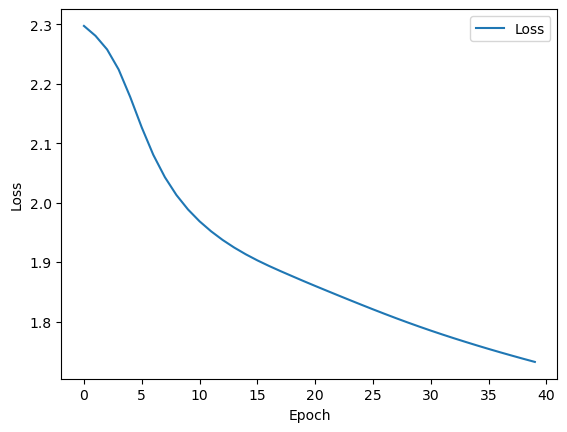

Saved PyTorch Model State to base_model.pth


In [60]:
run_experiment(base_model(), learning_rate=1e-3, epochs=40, optimizer_name='sgd', save_path="base_model.pth")

## Convolutional Neural Network
Below is a simple CNN model that I will use to demonstrate the power of CNNs on the CIFAR10 dataset.
This CNN has roughly the same number of parameters and complexity as the base model.

### Parameter count:
#### convoluted model

conv1: 3 x 12 x 3 x 3 + 12 = 336

conv2: 12 x 12 x 3 x 3 + 12 = 1308

fc1: 3072 x 64 + 64 = 196672

fc2: 64 x 10 + 10 = 650

total parameters: 336 + 1308 + 196672 + 650 = 198,966 ~ 200k

#### base model

fc1: 3 * 32* 32 * 64 + 64 = 196,672

fc2: 64 * 64 + 64 = 4,160

fc3: 64 * 10 + 10 = 650

total parameters: 196672 + 4160 + 650 = 201,482 ~ 200k



In [62]:
class base_conv_model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Two small convolutional layers, each with 12 output channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1)
        
        # Pool to reduce spatial dimension from 32x32 to 16x16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten before feeding into linear layers
        self.flatten = nn.Flatten()
        
        # After the pool layer, the spatial dimension is 16x16 and we have 12 channels
        # --> 12 * 16 * 16 = 3072
        self.fc1 = nn.Linear(12 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 10)
        
        # Non-linear activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolution + ReLU
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        
        # Pooling
        x = self.pool(x)
        
        # Flatten to [batch_size, 12*16*16]
        x = self.flatten(x)
        
        # Final fully-connected layers + ReLU in between
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

Epoch 1
-------------------------------
Loss: 2.304534, Accuracy: 9.8%
Epoch 2
-------------------------------
Loss: 2.302693, Accuracy: 10.1%
Epoch 3
-------------------------------
Loss: 2.300950, Accuracy: 11.3%
Epoch 4
-------------------------------
Loss: 2.298981, Accuracy: 13.9%
Epoch 5
-------------------------------
Loss: 2.296355, Accuracy: 17.2%
Epoch 6
-------------------------------
Loss: 2.292329, Accuracy: 17.9%
Epoch 7
-------------------------------
Loss: 2.285431, Accuracy: 19.0%
Epoch 8
-------------------------------
Loss: 2.272716, Accuracy: 20.2%
Epoch 9
-------------------------------
Loss: 2.247112, Accuracy: 21.1%
Epoch 10
-------------------------------
Loss: 2.195506, Accuracy: 23.0%
Epoch 11
-------------------------------
Loss: 2.116791, Accuracy: 25.3%
Epoch 12
-------------------------------
Loss: 2.050107, Accuracy: 27.0%
Epoch 13
-------------------------------
Loss: 2.008154, Accuracy: 28.4%
Epoch 14
-------------------------------
Loss: 1.977744, Accu

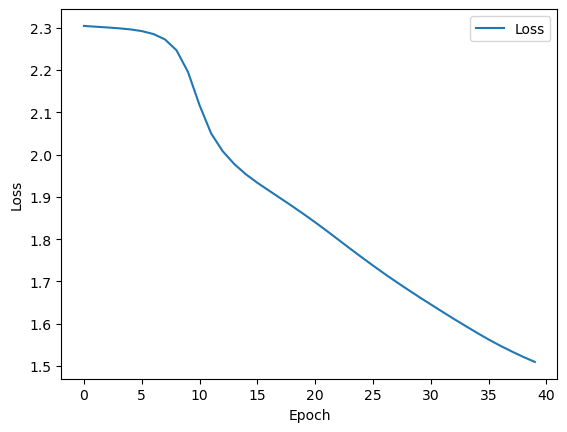

Saved PyTorch Model State to base_model.pth


In [63]:
run_experiment(base_conv_model(), learning_rate=1e-3, epochs=40, optimizer_name='sgd', save_path="base_model.pth")